Using TensorFlow backend.


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 1]]

 [[0 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 1]]

 ...

 [[0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 1]]

 [[0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 1]]

 [[0 0 1 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 1]]]





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_____________

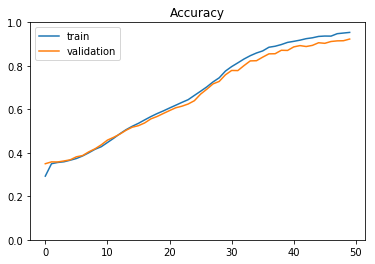

----------
Q:   80+789 
A:   869 
T/F: T
----------
Q:   873+561
A:   1434
T/F: T
----------
Q:   107+92 
A:   209 
T/F: F
----------
Q:   779+79 
A:   848 
T/F: F
----------
Q:   9+688  
A:   697 
T/F: T
----------
Q:   507+23 
A:   530 
T/F: T
----------
Q:   582+16 
A:   598 
T/F: T
----------
Q:   17+121 
A:   139 
T/F: F
----------
Q:   329+2  
A:   331 
T/F: T
----------
Q:   405+72 
A:   477 
T/F: T
----------


In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt


def n(digits=3):
  number = ''
  for i in range(np.random.randint(1, digits + 1)):
    number += np.random.choice(list('0123456789'))
  return int(number)


def padding(chars, maxlen):
  return chars + ' ' * (maxlen - len(chars))


'''
データの生成
'''
N = 20000
N_train = int(N * 0.9)
N_validation = N - N_train

digits = 3  # 最大の桁数
input_digits = digits * 2 + 1  # 例： 123+456
output_digits = digits + 1  # 500+500 = 1000 以上で４桁になる

added = set()
questions = []
answers = []

while len(questions) < N:
  a, b = n(), n()  # 適当な数を２つ生成

  pair = tuple(sorted((a, b)))
  if pair in added:
    continue

  question = '{}+{}'.format(a, b)
  question = padding(question, input_digits)
  answer = str(a + b)
  answer = padding(answer, output_digits)

  added.add(pair)
  questions.append(question)
  answers.append(answer)

chars = '0123456789+ '
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

X = np.zeros((len(questions), input_digits, len(chars)), dtype=np.integer)
Y = np.zeros((len(questions), digits + 1, len(chars)), dtype=np.integer)

for i in range(N):
  for t, char in enumerate(questions[i]):
    X[i, t, char_indices[char]] = 1
  for t, char in enumerate(answers[i]):
    Y[i, t, char_indices[char]] = 1

X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X, Y, train_size=N_train)

print(Y_train)

'''
モデル設定
'''
n_in = len(chars)
n_hidden = 128
n_out = len(chars)

model = Sequential()

# Encoder
model.add(LSTM(n_hidden, input_shape=(input_digits, n_in)))

# Decoder
model.add(RepeatVector(output_digits))
model.add(LSTM(n_hidden, return_sequences=True))

model.add(TimeDistributed(Dense(n_out)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001,
                             beta_1=0.9,
                             beta_2=0.999),
              metrics=['accuracy'])

model.summary()

'''
モデル学習
'''
epochs = 50
batch_size = 200

print(X_train.shape)
print(Y_train.shape)
h = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
              validation_data=(X_validation, Y_validation))

# accuracy と validation accuracy の推移をプロットする
plt.title('Accuracy')
plt.ylim(0.0, 1.0)
plt.plot(np.arange(len(h.history['acc'])), h.history['acc'], label='train')
plt.plot(np.arange(len(h.history['acc'])), h.history['val_acc'], label='validation')
plt.legend()
plt.show()

# 検証データからランダムに問題を選んで答え合わせ
for i in range(10):
  index = np.random.randint(0, N_validation)
  question = X_validation[np.array([index])]
  answer = Y_validation[np.array([index])]
  prediction = model.predict_classes(question, verbose=0)

  question = question.argmax(axis=-1)
  answer = answer.argmax(axis=-1)

  q = ''.join(indices_char[i] for i in question[0])
  a = ''.join(indices_char[i] for i in answer[0])
  p = ''.join(indices_char[i] for i in prediction[0])

  print('-' * 10)
  print('Q:  ', q)
  print('A:  ', p)
  print('T/F:', end=' ')
  if a == p:
    print('T')
  else:
    print('F')
print('-' * 10)